In [ ]:
# Selected GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14522164350772962145
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17970015412822386954
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import shutil
import itertools

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

RANDOM_SEED = 42

In [2]:
def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [3]:
train_dir = '/content/drive/My Drive/Dataset_200/dataset/train/'
test_dir = '/content/drive/My Drive/Dataset_200/dataset/test/'
validation_dir = '/content/drive/My Drive/Dataset_200/dataset/validation/'

In [4]:
IMG_SIZE = (224,224)

X_train, y_train, labels = load_data(train_dir, IMG_SIZE)
X_test, y_test, _ = load_data(test_dir, IMG_SIZE)
X_val, y_val, _ = load_data(validation_dir, IMG_SIZE)

100%|██████████| 2/2 [00:45<00:00, 22.59s/it]


1536 images loaded from /content/drive/My Drive/Dataset_200/dataset/train/ directory.


100%|██████████| 2/2 [00:14<00:00,  7.10s/it]


480 images loaded from /content/drive/My Drive/Dataset_200/dataset/test/ directory.


100%|██████████| 2/2 [00:08<00:00,  4.50s/it]

384 images loaded from /content/drive/My Drive/Dataset_200/dataset/validation/ directory.


In [5]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 227, 227, 3)
(480, 227, 227, 3)
(384, 227, 227, 3)


In [6]:
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])

In [7]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(1536, 224, 224, 3)
(480, 224, 224, 3)
(384, 224, 224, 3)


In [8]:
input_shape = (224,224, 3)
batch_size = 32

In [9]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


# Inception V3

In [22]:
pretrained_inceptionv3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pretrained_inceptionv3_model.trainable = False

In [23]:
def print_layer_trainable():
    for layer in pretrained_inceptionv3_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

# for layer in pretrained_inceptionv3_model.layers[-20:]:
#     layer.trainable = True

# print_layer_trainable()

print('Num layers, ', len(pretrained_inceptionv3_model.layers))

Num layers,  311


In [24]:
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU

model_inceptionv3 = tf.keras.Sequential([
                             pretrained_inceptionv3_model,
                             tf.keras.layers.Flatten(),
                            #  tf.keras.layers.Dense(16, activation='relu'), #1024
                            #  tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')
                             ])

model_inceptionv3.compile(
    # optimizer=Adam(lr=1e-5),
    optimizer=RMSprop(lr=1e-4),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

model_inceptionv3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [25]:
EPOCHS = 50
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    # min_delta=0.000001,
    patience=6,
    min_lr=1e-6,
    verbose=1)

# es = EarlyStopping(
#     monitor='val_accuracy', 
#     mode='max',
#     patience=6
# )

filename = '/content/drive/MyDrive/models/Defense/InceptionV3.h5'
check_pt = ModelCheckpoint(
    filename,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True
)

history = model_inceptionv3.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, check_pt])

Epoch 1/50
48/48 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.7415
Epoch 1: val_accuracy improved from -inf to 0.84635, saving model to /content/drive/MyDrive/models/Defense/InceptionV3.h5
48/48 [==============================] - 22s 353ms/step - loss: 0.5636 - accuracy: 0.7415 - val_loss: 0.3258 - val_accuracy: 0.8464 - lr: 1.0000e-04
Epoch 2/50
48/48 [==============================] - ETA: 0s - loss: 0.2490 - accuracy: 0.9069
Epoch 2: val_accuracy improved from 0.84635 to 0.94271, saving model to /content/drive/MyDrive/models/Defense/InceptionV3.h5
48/48 [==============================] - 13s 267ms/step - loss: 0.2490 - accuracy: 0.9069 - val_loss: 0.1809 - val_accuracy: 0.9427 - lr: 1.0000e-04
Epoch 3/50
48/48 [==============================] - ETA: 0s - loss: 0.1645 - accuracy: 0.9382
Epoch 3: val_accuracy improved from 0.94271 to 0.95052, saving model to /content/drive/MyDrive/models/Defense/InceptionV3.h5
48/48 [==============================] - 13s 267

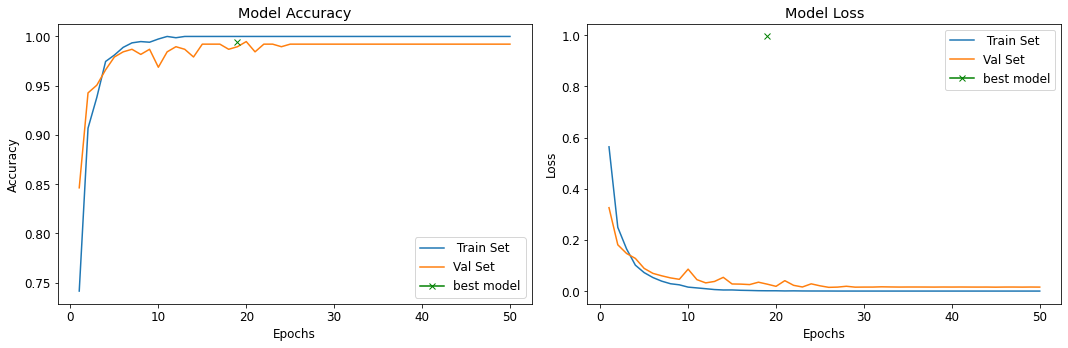

In [26]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
# plt.plot(28, 0.9766, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
plt.plot( np.argmax(model_inceptionv3.history.history["val_accuracy"]), np.max(model_inceptionv3.history.history["val_accuracy"]), marker="x", color="g", label="best model")
# plt.axvline(x=28, color="black")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
# plt.plot(28, 0.0750, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red")
plt.plot( np.argmax(model_inceptionv3.history.history["val_accuracy"]), np.max(model_inceptionv3.history.history["val_accuracy"]), marker="x", color="g", label="best model")
# plt.axvline(x=28, color="black")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [27]:
from tensorflow.keras.models import load_model
# saved_model = load_model('/content/drive/MyDrive/models/Xception.h5')
saved_model = load_model('/content/drive/MyDrive/models/Defense/InceptionV3.h5', compile = False)

saved_model.compile(
    optimizer=RMSprop(lr=1e-4),
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [28]:
# validate on validation set
predictions = saved_model.predict(X_val / 255)
predictions = [1 if x>0.5 else 0 for x in predictions]
# predictions = [1 if x>0.4 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train / 255, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val / 255, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.9987, Val: 0.9818
Validation Accuracy = 0.9818
Precision: 0.984293
Recall: 0.979167
F1 score: 0.981723
Cohens kappa: 0.963542
ROC AUC: 0.981771
[[189   3]
 [  4 188]]
True positive: 188 , True negative: 189 , False positive: 3 , False negative: 4


Train: 0.9987, Test: 0.9896
Test Accuracy = 0.9896
Precision: 0.987552
Recall: 0.991667
F1 score: 0.989605
Cohens kappa: 0.979167
ROC AUC: 0.989583
[[237   3]
 [  2 238]]
True positive: 238 , True negative: 237 , False positive: 3 , False negative: 2
Sensitivity: 0.9917
Specificity: 0.9875


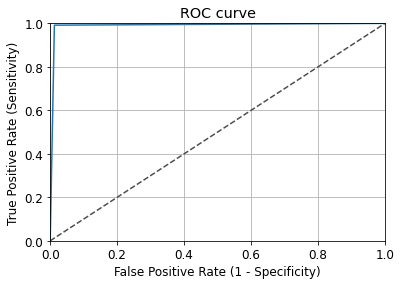

In [29]:
# validate on test set
predictions = saved_model.predict(X_test / 255)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = saved_model.evaluate(X_train / 255, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test / 255, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

Train: 0.9987, Test: 0.9875
Test Accuracy = 0.9875
Precision: 0.991597
Recall: 0.983333
F1 score: 0.987448
Cohens kappa: 0.975000
ROC AUC: 0.987500
[[238   2]
 [  4 236]]
True positive: 236 , True negative: 238 , False positive: 2 , False negative: 4
Sensitivity: 0.9833
Specificity: 0.9917


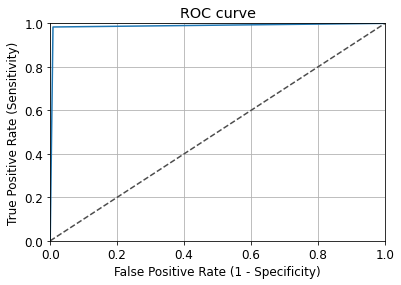

In [30]:
# validate on test set
predictions = model_inceptionv3.predict(X_test / 255)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model_inceptionv3.evaluate(X_train / 255, y_train, verbose=0)
_, test_acc = model_inceptionv3.evaluate(X_test / 255, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [ ]:
# model_inceptionv3.save_weights("inceptionv3-9917.h5")
# predictions = model_inceptionv3.predict(X_test / 255)
# predictions